In [1]:
import pyglet
import pyglet.media
import time
import numpy as np

In [2]:
class TimeoutLoop:
    """ universal for time-out loop """
    def __init__(self, timeout):
        self.timeout = timeout
    def __iter__(self):
        self.start_time = time.time()
        return self
    def __next__(self):
        now = time.time()
        time_passed = now - self.start_time
        if time_passed > self.timeout: 
            raise StopIteration
        else:
            return time_passed

def generate_sound(dist, x, y):
    #global player 
    player = pyglet.media.Player()
    player.play()
    
    audio_x = x
    audio_y = y
    audio_z = dist/3

    audio_dur = min(dist/2, 0.15)
    idle_dur = dist

    freq = 400 + y*100

    wave = pyglet.media.synthesis.Triangle(audio_dur, freq)
    wave.play()
    player.position = (audio_x, audio_y, audio_z)
    
    player.queue(wave)

    time.sleep(audio_dur+idle_dur)
    player.delete()

In [3]:
for x in np.arange(-1.5,1.5,0.2):
    generate_sound(0.5, x, 0)


In [4]:
for y in np.arange(-1,1,0.2):
    generate_sound(0.1, 0, y)

In [5]:
for z in np.arange(1,0.05,-0.05):
    for i in range(1):
        generate_sound(z, 0, 0)
    #time.sleep(1)

Enabling RS camera


/home/jetson/.local/lib/python3.6/site-packages/ipykernel_launcher.py:100: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Otsu threshold: 97
Step-by-step MTSMO: [74, 108, 41, 192, 200]
MTSMO: [74, 108, 41, 192, 200]


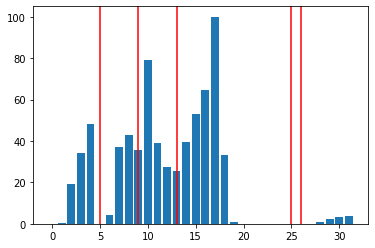

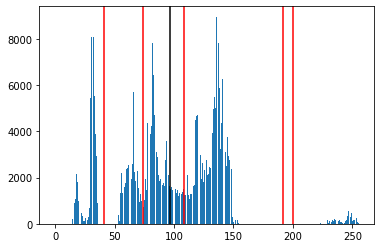

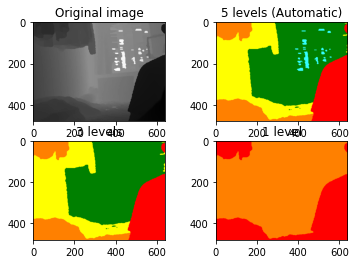

In [5]:
import cv2
import otsu
import matplotlib.pyplot as plt
import numpy as np
import argparse

import time
from pathlib import Path

import cv2
from numpy import random

import pyrealsense2 as rs
import numpy as np
from multiprocessing.connection import Client

def show_thresholds(src_img, dst_img, thresholds):
    """Visualise thresholds."""
    colors = [(255, 0, 0), (255, 128, 0), (255, 255, 0), (0, 128, 0), (0, 204, 102),
              (51, 255, 255), (0, 128, 255), (0, 0, 255), (128, 0, 255), (255, 0, 255), (255, 0, 127)]
    masks = otsu.multithreshold(src_img, thresholds)
    for i, mask in enumerate(masks):
        # for debugging masks
        # background = np.zeros((dst_img.shape[0], dst_img.shape[1], 3))
        # background[mask] = (255, 255, 255)
        # plt.figure()
        # plt.imshow(background)
        dst_img[mask] = colors[i]
    return dst_img


def full_method(img, L=256, M=32):
    """Obtain thresholds and image masks directly from image.
    Abstracts away the need to handle histogram generation.
    """
    # Calculate histogram
    hist = cv2.calcHist(
        [img],
        channels=[0],
        mask=None,
        histSize=[L],
        ranges=[0, L]
    )

    thresholds = otsu.modified_TSMO(hist, M=M, L=L)
    masks = otsu.multithreshold(img, thresholds)
    return thresholds, masks


config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

print('Enabling RS camera')
pipeline = rs.pipeline()
profile = pipeline.start(config)

sensor_dep = profile.get_device().first_depth_sensor()
sensor_dep.set_option(rs.option.min_distance, 100)
#sensor_dep.set_option(rs.option.enable_max_usable_range, 1)
sensor_dep.set_option(rs.option.laser_power, 100)
sensor_dep.set_option(rs.option.receiver_gain, 18)
sensor_dep.set_option(rs.option.confidence_threshold, 1)
sensor_dep.set_option(rs.option.noise_filtering, 2)

depth_scale = sensor_dep.get_depth_scale()

align_to = rs.stream.color
align = rs.align(align_to)

t1 = time.perf_counter()
#print(f' ({(1E3 * (t1 - t0)):.1f}ms) boot\n')

if True:
    while True:
        try:
            frames = pipeline.wait_for_frames()
        except:
            print('Cam recv no frames')
        else:
            break

    aligned_frames = align.process(frames)
    color_frame = aligned_frames.get_color_frame()
    depth_frame = aligned_frames.get_depth_frame()
    #if not depth_frame or not color_frame:
    #    continue

    # filtering
    spatial = rs.spatial_filter(smooth_alpha=0.5,smooth_delta=30,magnitude=1,hole_fill=5)
    hole_filling = rs.hole_filling_filter(1)

    #depth_frame = depth_to_disparity.process(depth_frame)
    depth_frame = spatial.process(depth_frame)
    #depth_frame = disparity_to_depth.process(depth_frame)
    depth_frame = hole_filling.process(depth_frame)

    img = np.asanyarray(depth_frame.get_data())
    invalid = np.full((480,640),65536, dtype=np.uint16)
    img = np.where(img[:,:] == [0,0], invalid, img)

    #depth_img = cv2.bilateralFilter((depth_img/256.0).astype(np.uint8), 9, 75, 75)
    img = cv2.medianBlur(img,5)

    img = (img // 64).astype(np.uint8).clip(0,255)

    depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(img, alpha=0.03), cv2.COLORMAP_JET)

    L = 256  # number of levels
    M = 32  # number of bins for bin-grouping normalisation

    N = L // M

    # Calculate histogram
    hist = cv2.calcHist(
        [img],
        channels=[0],
        mask=None,
        histSize=[L],
        ranges=[0, L]
    )

    ### Do modified TSMO step by step
    # Normalise bin histogram
    norm_hist = otsu.normalised_histogram_binning(hist, M=M, L=L)

    # Estimate valley regions
    valleys = otsu.find_valleys(norm_hist)
    # plot valleys
    plt.figure()
    plt.bar(range(0, norm_hist.shape[0]), norm_hist.ravel())
    for v in valleys:
        plt.axvline(x=v, color='red')
    thresholds = otsu.threshold_valley_regions(hist, valleys, N)
    ###

    # modified_TSMO does all the steps above
    thresholds2 = otsu.modified_TSMO(hist, M=M, L=L)

    # Threshold obtained through default otsu method.
    otsu_threshold, _ = otsu.otsu_method(hist)

    print('Otsu threshold: {}\nStep-by-step MTSMO: {}\nMTSMO: {}'.format(
        otsu_threshold, thresholds, thresholds2))

    # Show histogram with thresholds
    plt.figure()
    plt.bar(range(0, hist.shape[0]), hist.ravel())
    plt.axvline(x=otsu_threshold, color='k')
    for t in thresholds:
        plt.axvline(x=t, color='red')

    # Illustrate thresholds
    img_1 = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_3 = img_1.copy()
    img_auto = img_1.copy()

    show_thresholds(img, img_1, [thresholds[0]])
    show_thresholds(img, img_3, thresholds[0:3])
    show_thresholds(img, img_auto, thresholds)

    plt.figure()
    ax = plt.subplot(2, 2, 1)
    ax.set_title('Original image')
    plt.imshow(img, cmap='gray')
    ax = plt.subplot(2, 2, 2)
    ax.set_title('{} levels (Automatic)'.format(len(thresholds)))
    plt.imshow(img_auto)
    ax = plt.subplot(2, 2, 3)
    ax.set_title('3 levels')
    plt.imshow(img_3)
    ax = plt.subplot(2, 2, 4)
    ax.set_title('1 level')
    plt.imshow(img_1)
    plt.show()